<a href="https://colab.research.google.com/github/whopriyam/IECSE-ML-Meet-/blob/master/MNIST_F_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
###Importing the Reqd Libraries

import keras
from keras.models import Sequential,Model
from keras.layers.core import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [0]:
###Importing the Dataset

from keras.datasets.fashion_mnist import load_data

(X_train_orig,Y_train_orig),(X_test_orig,Y_test_orig) = load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
###Overview of Imported Data

print("X_train Shape:",X_train_orig.shape)
print("Y_train Shape:",Y_train_orig.shape)
print("X_test Shape:",X_test_orig.shape)
print("Y_test Shape:",Y_test_orig.shape)

X_train Shape: (60000, 28, 28)
Y_train Shape: (60000,)
X_test Shape: (10000, 28, 28)
Y_test Shape: (10000,)


In [0]:
###Label Dictionary

label_dict = {0:'T-shirt/top',
1:'Trouser',
2:'Pullover',
3:'Dress',
4:'Coat',
5:'Sandal',
6:'Shirt',
7:'Sneaker',
8:'Bag',
9:'Ankle boot'}

Sandal


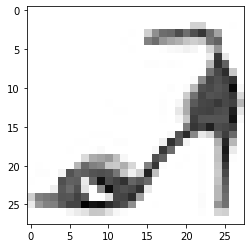

In [0]:
###Visualizing a Training Example

img_index = 2323
img = X_train_orig[img_index]
label = Y_train_orig[img_index]

print(label_dict[label])
plt.imshow(img,cmap='Greys')

In [0]:
###Pre-Processing the Data

##Normalizing the Data
X_train = X_train_orig/255
X_test = X_test_orig/255

In [0]:
##One Hot encoding

Y_train = keras.utils.to_categorical(Y_train_orig,10)
Y_test = keras.utils.to_categorical(Y_test_orig,10)

In [0]:
###Overview Of Processed Data

print("X_train Shape:",X_train.shape)
print("Y_train Shape:",Y_train.shape)
print("X_test Shape:",X_test.shape)
print("Y_test Shape:",Y_test.shape)


X_train Shape: (60000, 28, 28)
Y_train Shape: (60000, 10)
X_test Shape: (10000, 28, 28)
Y_test Shape: (10000, 10)


In [0]:
###Function for Resizing

from skimage.transform import resize

target_size = 150

def preprocess_image(x):
    # Resize the image to have the shape of (150,150)
    x = resize(x, (target_size, target_size),mode='constant',anti_aliasing=False)

    x = np.stack((x,)*3, axis=-1) 

    return x.astype(np.float32)

In [0]:
###Making a Generator

from sklearn.utils import shuffle

def load_data_generator(x, y, batch_size=64):
    num_samples = x.shape[0]
    while 1:  # Loop forever so the generator never terminates
        try:
            shuffle(x)
            for i in range(0, num_samples, batch_size):
                x_data = [preprocess_image(im) for im in x[i:i+batch_size]]
                y_data = y[i:i + batch_size]
            
                # convert to numpy array since this what keras required
                yield shuffle(np.array(x_data), np.array(y_data))
        except Exception as err:
            print(err)

In [0]:
###Image Hyperparameters

IMAGE_SIZE = 150
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE,IMAGE_SIZE
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [0]:
###Making the Model
from keras.applications import VGG16

input_shape = (IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_CHANNELS)

model = Sequential

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:-5]:
    layer.trainable = False
for layer in pre_trained_model.layers[-5:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = Dense(10, activation='softmax')(x)

model = Model(pre_trained_model.input, x)





58892288/58889256 [==============================] - 2s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
###Model Summary

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [0]:
###Compiling the Model
from keras import optimizers

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0001),metrics=['categorical_accuracy'])

In [0]:
###Callbacks

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

###Callbacks

learning_rate_reduction = ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystop = EarlyStopping(patience=10)

callbacks = [earlystop, learning_rate_reduction]

In [0]:
###Hyperparameters

batch_size=64
epochs = 20

In [0]:
train_generator = load_data_generator(X_train, Y_train, batch_size=batch_size)
val_generator = load_data_generator(X_test, Y_test, batch_size=batch_size)
total_train = X_train.shape[0]
total_validate = X_test.shape[0]

###Training the Model

history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
    validation_data=val_generator,
    validation_steps=total_validate//batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
937/937 [==============================] - 200s 213ms/step - loss: 0.3437 - categorical_accuracy: 0.8772 - val_loss: 0.2640 - val_categorical_accuracy: 0.9050
Epoch 2/20
937/937 [==============================] - 197s 210ms/step - loss: 0.2107 - categorical_accuracy: 0.9243 - val_loss: 0.2361 - val_categorical_accuracy: 0.9171
Epoch 3/20
937/937 [==============================] - 194s 207ms/step - loss: 0.1633 - categorical_accuracy: 0.9412 - val_loss: 0.2476 - val_categorical_accuracy: 0.9156
Epoch 4/20
937/937 [==============================] - 196s 209ms/step - loss: 0.1319 - categorical_accuracy: 0.9527 - val_loss: 0.2654 - val_categorical_accuracy: 0.9148

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/20
937/937 [==============================] - 194s 207ms/step - loss: 0.0837 - categorical_accuracy: 0.9697 - val_loss: 0.2671 - val_ca

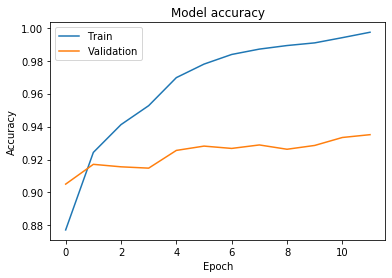

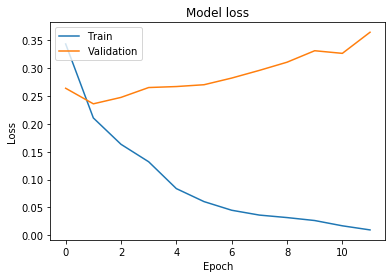

In [0]:
###Plotting the Results

##Accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

##Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
###Performance on the Test Set

results = model.evaluate(X_test, Y_test, batch_size=batch_size)
print('test loss, test acc:', results)

ValueError: ignored